### Interpretability - feature metrics

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [15]:
coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")
met_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/metabolite_clean.csv")
coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')

X = coral_df[coral_df.columns.intersection(met_df['metabolite'])]
y = coral_df['scleractinia']
# X = X.to_numpy()
# y = y.to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88, stratify=y)


/tmp/ipykernel_3095122/4262015104.py:1: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")


### Feature selection

In [16]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

## variance threshold doesn't remove enough testing Kbest and percentile

In [ ]:
# Initialize a dictionary to store the dataframes
importance_storage = {}

# Define your datasets and models
datasets = {
    "KBest_500": SelectKBest(f_classif, k=500),
    "Percentile_5": SelectPercentile(f_classif, percentile=5)
}

models = {
    "RandomForest": RandomForestClassifier(random_state=88, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=88, use_label_encoder=False, eval_metric='logloss')
}

# Original feature names from the intersection
feature_names = coral_df.columns.intersection(met_df['metabolite']).values

for d_name, selector in datasets.items():
    selector.fit(X_train, y_train)
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
    
    mask = selector.get_support()
    selected_features = feature_names[mask]
    
    for m_name, model in models.items():
        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_test_sel)
        
        print(f"\n{m_name} on {d_name}")
        print(confusion_matrix(y_test, y_pred))
        
        feat_imp_df = pd.DataFrame({
            'Metabolite': selected_features,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
        
        importance_storage[f"{m_name}_{d_name}"] = feat_imp_df

# importance_storage

/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  149   202   268   288   370   449   488   546   572   708   847   948
   950   966  1019  1098  1122  1127  1247  1334  1437  1470  1499  1696
  1839  1844  1916  2010  2097  2201  2271  2390  2445  2589  2674  2870
  3032  3169  3172  3446  3470  3641  3720  4253  4263  4297  4326  4382
  4416  4569  4788  4823  4909  5384  5764  5993  6044  6048  6138  6606
  6689  6793  6825  6932  7156  7305  7475  7497  7847  7906  8084  8182
  8193  8677  9274  9452  9472  9713  9768  9889 10107 10201 10384 10755
 10810 11793 12105 12316 12446 12620 12654 12688 13026 13113 13262 13279
 13626 14143 14157 14374 15230 15271 15352 15594 16337] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_uni


RandomForest on KBest_500
[[28  0]
 [ 0 86]]


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:01:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost on KBest_500
[[28  0]
 [ 0 86]]


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  149   202   268   288   370   449   488   546   572   708   847   948
   950   966  1019  1098  1122  1127  1247  1334  1437  1470  1499  1696
  1839  1844  1916  2010  2097  2201  2271  2390  2445  2589  2674  2870
  3032  3169  3172  3446  3470  3641  3720  4253  4263  4297  4326  4382
  4416  4569  4788  4823  4909  5384  5764  5993  6044  6048  6138  6606
  6689  6793  6825  6932  7156  7305  7475  7497  7847  7906  8084  8182
  8193  8677  9274  9452  9472  9713  9768  9889 10107 10201 10384 10755
 10810 11793 12105 12316 12446 12620 12654 12688 13026 13113 13262 13279
 13626 14143 14157 14374 15230 15271 15352 15594 16337] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/sklearn/feature_selection/_uni


RandomForest on Percentile_5
[[28  0]
 [ 0 86]]


/hpc/group/schultzlab/hs325/miniconda3/envs/gsAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:01:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost on Percentile_5
[[28  0]
 [ 0 86]]


Next steps are to investigate the feature importances of the Kbest and percentile feature sets for RF and GB and look at the top metabolites to try to define a core coral metabolome  
-> we may try to choose only metabolites where diff in scleractinia and others are large (i.e. select only metabolites found predominantly in corals to do the prediction)

### Perm importance with multicollinear features

In [18]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict


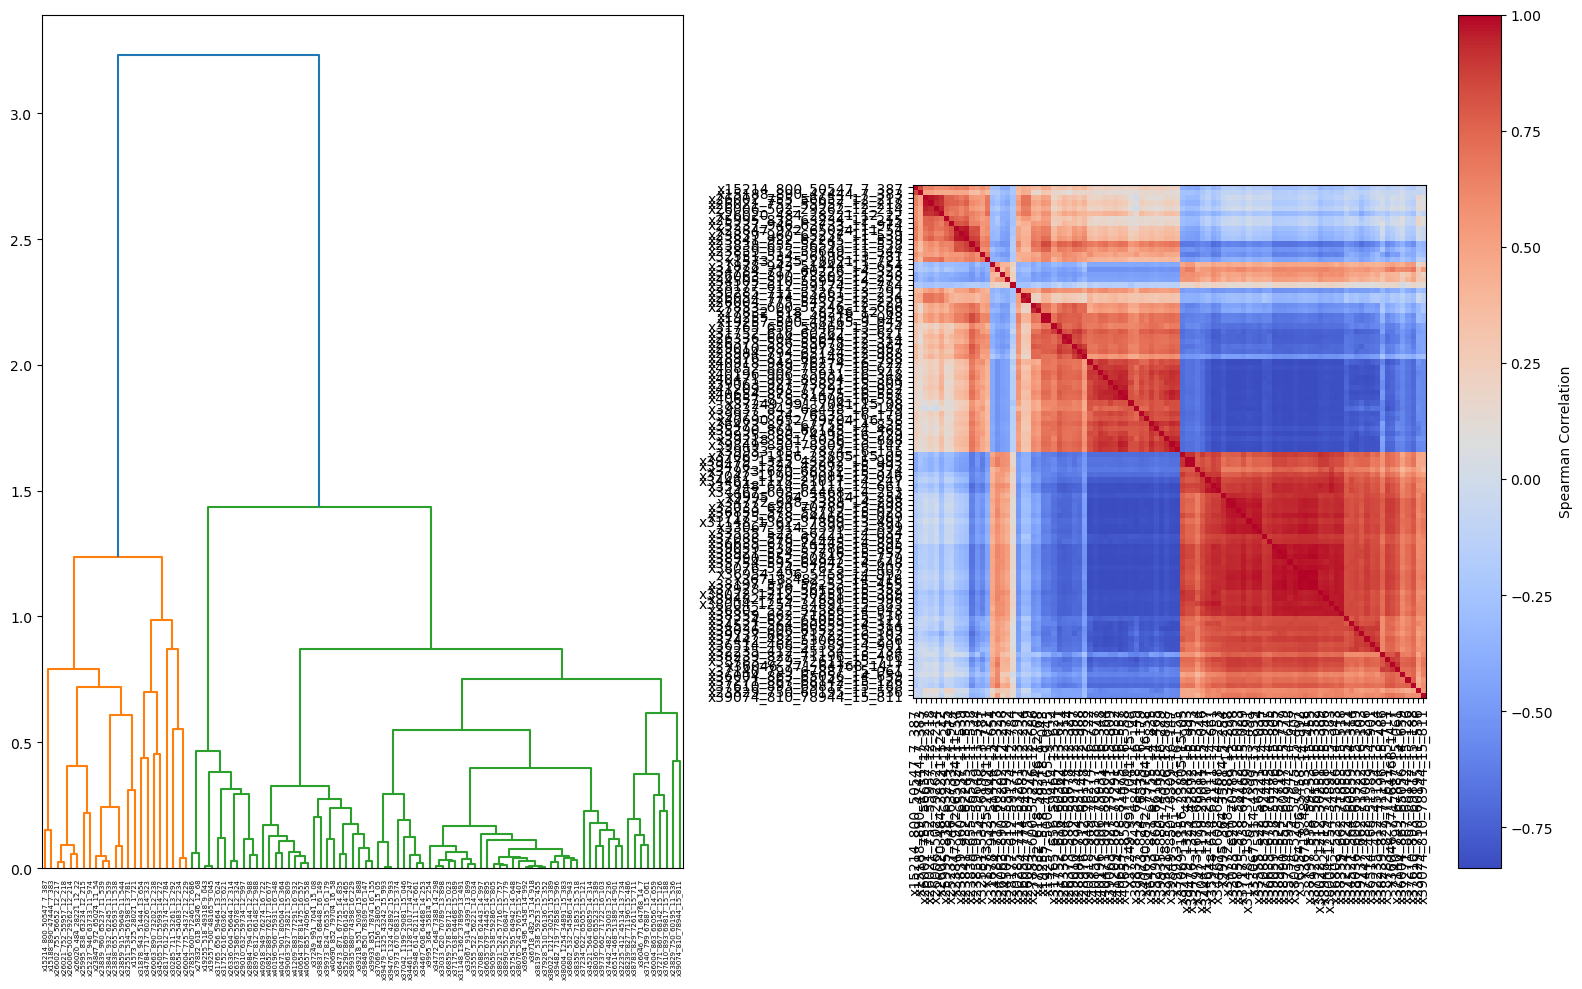

In [34]:
top_100_metabolites = importance_storage["RandomForest_KBest_500"].head(100)['Metabolite'].values
# top_100_metabolites = importance_storage["XGBoost_KBest_500"].head(100)['Metabolite'].values
## best downstream model accuracy is RF KBest500 with 93% using just 4 features

X_df = pd.DataFrame(X, columns=coral_df.columns.intersection(met_df['metabolite']))
X_subset = X_df[top_100_metabolites]

corr = spearmanr(X_subset).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

dendro = hierarchy.dendrogram(
    dist_linkage, labels=top_100_metabolites.tolist(), ax=ax1, leaf_rotation=90
)

im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap='coolwarm')
ax2.set_xticks(np.arange(len(top_100_metabolites)))
ax2.set_yticks(np.arange(len(top_100_metabolites)))
ax2.set_xticklabels([top_100_metabolites[i] for i in dendro["leaves"]], rotation=90)
ax2.set_yticklabels([top_100_metabolites[i] for i in dendro["leaves"]])

fig.colorbar(im, ax=ax2, label='Spearman Correlation')
fig.tight_layout()
plt.show()

In [33]:
from collections import defaultdict
from scipy.cluster import hierarchy

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")

cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features_indices = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = feature_names[selected_features_indices]

print(f"Reduced feature set from {len(feature_names)} to {len(selected_features_names)} clusters.")

X_train_sel = X_train[:, selected_features_indices]
X_test_sel = X_test[:, selected_features_indices]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_sel.fit(X_train_sel, y_train)

accuracy = clf_sel.score(X_test_sel, y_test)
print(f"Baseline accuracy on test data with redundant features removed: {accuracy:.2f}")

## print selected feature names
print("Selected feature names after clustering:")
for name in selected_features_names:
    print(name)

Reduced feature set from 16368 to 4 clusters.
Baseline accuracy on test data with redundant features removed: 0.87
Selected feature names after clustering:
x19344_800_60417_9_097
x22863_768_59077_10_971
x20449_766_57519_9_667
x22285_536_50395_10_6


### Explainability metrics - SHAP/ALE


In [ ]:
## import feature importance comparison df
feature_importance_comparison_df = pd.read_csv("/work/hs325/World_Corals/machine_learning/coral_mets_only/featureimportancecoralmets.csv")

In [ ]:
original_cols = feature_importance_comparison_df.columns.tolist()
met_df_indexed = met_df.set_index('metabolite')
merged_df = feature_importance_comparison_df.merge(
    met_df_indexed,
    left_index=True,
    right_index=True,
    how='inner'
)
merged_df

,Feature,XGBoost_Importance,RandomForest_Importance,feature_id,compound_superclass,molecular_formula,adduct,precursor_formula,npc_number_pathway,npc_number_pathway_probability,...,coraldb_mz_error_ppm,coraldb_compound_family,coraldb_compound_superclass,coraldb_compound_class,exact_mass,database,clusterIndex,refined_origin,compound_class,coraldb_compound_name


GB best params =  OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 558, 'subsample': 0.5})

RF best params =  OrderedDict({'max_depth': 39, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 19, 'n_estimators': 343})


In [ ]:
import shap
# from PyALE import ale
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import effector
import lime
from anchor import anchor_tabular


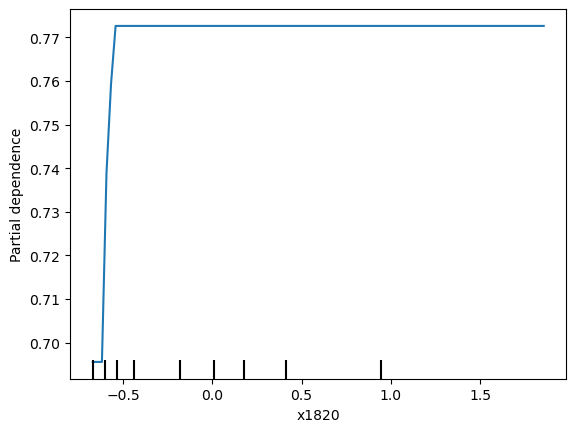

In [ ]:
features = [1820]
## must retrain models using feature indices - input the top features from merged_df and make PDPs/ALEs

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(gb, X_test, features, kind='average') #kind='both'

## run ALE plot for this feature


In [ ]:
## may have to run this on cluster

perm_imp = permutation_importance(gb, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in perm_imp.importances_mean.argsort()[::-1]:
    if perm_imp.importances_mean[i] - 2 * perm_imp.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{perm_imp.importances_mean[i]:.3f}"
              f" +/- {perm_imp.importances_std[i]:.3f}")


In [ ]:
sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(X_test.columns[sorted_idx], perm_imp.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [ ]:
## Anchor

## must debug
class_names = ['<=50K', '>50K']

explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    X_train.values,
)
idx = 100

exp = explainer.explain_instance(X_test.values[idx], gb.predict, threshold=0.80)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())


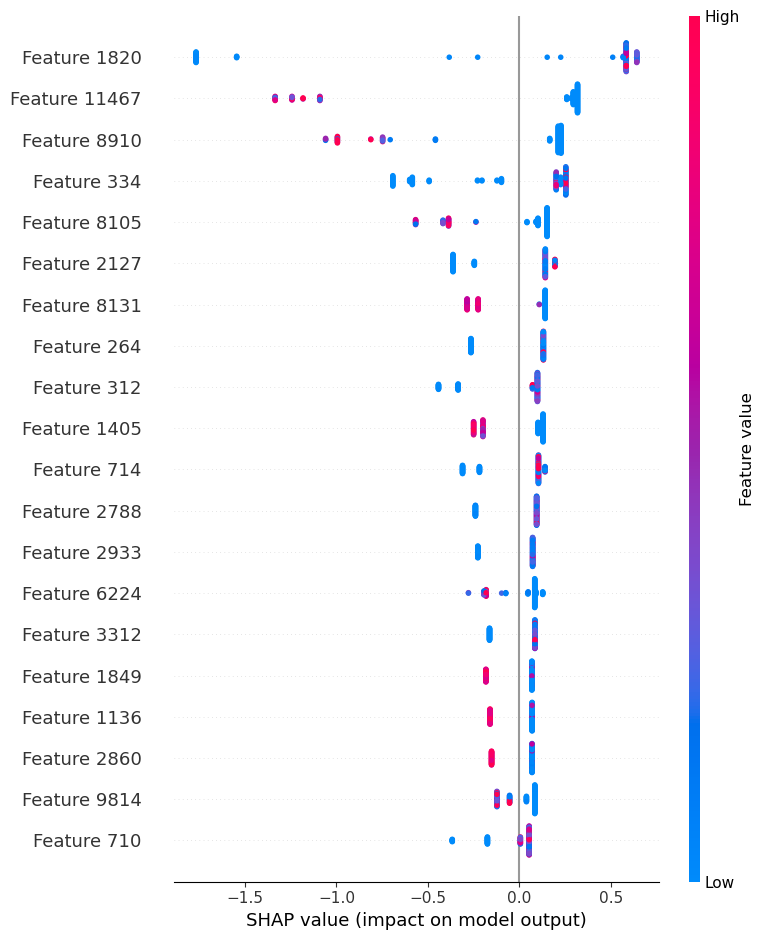

In [ ]:
## Shap
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer = shap.TreeExplainer(gb, X100) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test
shap.summary_plot(shap_values, X_test)



In [ ]:
feature_name_df = coral_df[coral_df.columns.intersection(met_df['metabolite'])]
feature_name_df.iloc[:,1820]

0      50029.810
1      12667.683
2      68022.780
3      50144.520
4      93021.980
         ...    
592    12680.457
593        0.000
594    10123.123
595    17453.530
596    17232.861
Name: x15256_518_49365_7_407, Length: 597, dtype: float64

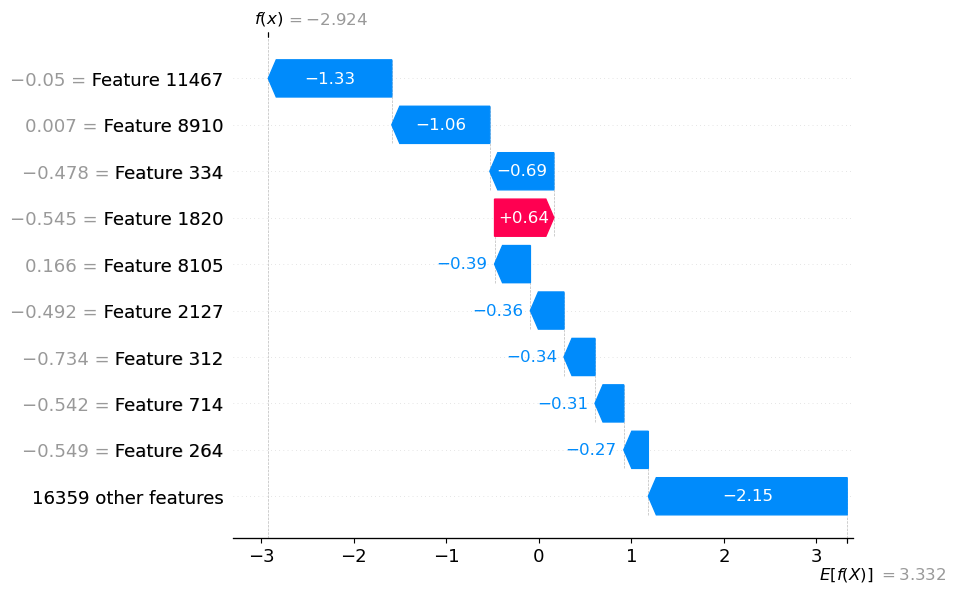

In [ ]:
idx = 100
shap.plots.waterfall(shap_values_exp[idx])

### Visualize feature importance on original XGB model

In [12]:
df = pd.read_csv("/work/hs325/World_Corals/machine_learning/all_mets/featureimportanceallmets.csv")
df

,Feature,XGBoost_Importance,RandomForest_Importance
0,x39975_976_83346_16_206,0.112172,0.004803
1,x39055_948_80202_15_826,0.104181,0.006981
2,x1014_394_26002_1_302,0.096209,0.008638
3,x23838_655_56593_11_538,0.078475,0.009619
4,x15256_518_49365_7_407,0.079553,0.007225
...,...,...,...
16363,x22259_709_6159_10_572,0.000000,0.000000
16364,x22260_791_59633_10_59,0.000000,0.000000
16365,x22264_675_5427_10_582,0.000000,0.000000
16366,x22265_593_56163_10_6,0.000000,0.000000


In [14]:
## count number of nonzero rows in xgboost_importance column
num_features = (df['RandomForest_Importance'] != 0).sum()
num_features

2765